In [1]:
## install finrl library
!pip install wrds
!pip install swig
!pip install yfinance gymnasium stable-baselines3 matplotlib pandas
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pandas_market_calendars
!pip install lxml

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/y_/g6cc4yls171g553vr7p9jg2w0000gn/T/pip-req-build-x69h67d7
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/y_/g6cc4yls171g553vr7p9jg2w0000gn/T/pip-req-build-x69h67d7
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 9e8c38aa5b92bbf0e20f65fc611fd43b43196859
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/y_/g6cc4yls171g553vr7p9jg2w0000gn/T/pip-install-avxrf215/elegantrl_77e5e9ff0e0f47a2b5e632687216a07d
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/y_/g6cc4yls171g553vr7p9jg2w0000gn/T/pip-install-avxrf215/elegantrl_77e5e9ff0e0f47a2b5e632687216a07d
  

In [2]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

import itertools

In [5]:
def get_sp500_tickers(): # Gets the SP500 stocks by webscraping Wikipedia
    import requests
    
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # Add headers to avoid 403 Forbidden error
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        # Use requests with headers, then pass to pandas
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        # The table we want is the first one on the page
        table = pd.read_html(response.content, header=0)[0]
        # The ticker symbols are in the 'Symbol' column
        tickers = table['Symbol'].tolist()
        # Some tickers on Wikipedia might have a different format, this will standardize them
        tickers = [ticker.replace('.', '-') for ticker in tickers]
        return tickers
    except Exception as e:
        print(f'An error occurred: {e}')
        # Fallback: return a hardcoded list of major S&P 500 tickers
        print('Using fallback ticker list...')
        return ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'BRK-B', 'UNH', 'JNJ']

# Test the function
sp500_tickers = get_sp500_tickers()
print(f'Successfully retrieved {len(sp500_tickers)} tickers')
print(f'First 10: {sp500_tickers[:10]}')


Successfully retrieved 503 tickers
First 10: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [6]:
TRAIN_START_DATE = '2019-01-01'
TRAIN_END_DATE = '2022-01-01'
TRADE_START_DATE = '2022-01-01'
TRADE_END_DATE = '2024-12-31'

In [7]:
if sp500_tickers:
  # Download the data
  df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                           end_date= TRADE_END_DATE,
                           ticker_list=sp500_tickers).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (747070, 8)


In [8]:
df_raw.head()

Price        date      close       high        low       open     volume  \
0      2019-01-02  62.679523  63.519192  62.307397  63.452400    2113300   
1      2019-01-02  37.575207  37.796491  36.697214  36.854254  148158800   
2      2019-01-02  66.327263  67.836220  65.725162  67.821350    6908400   
3      2019-01-02  61.766026  63.063556  61.383876  62.556986    8737200   
4      2019-01-02  24.904034  25.217830  24.761399  25.075196     818400   

Price   tic  day  
0         A    2  
1      AAPL    2  
2      ABBV    2  
3       ABT    2  
4      ACGL    2

In [9]:
# Check for missing values
print(df_raw.isnull().sum())

Price
date      0
close     0
high      0
low       0
open      0
volume    0
tic       0
day       0
dtype: int64


In [10]:
# Attach technical indicators to dataframe
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (1508, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [12]:
processed_full.head()

date   tic      close       high        low       open       volume  \
0  2019-01-02     A  62.679523  63.519192  62.307397  63.452400    2113300.0   
1  2019-01-02  AAPL  37.575207  37.796491  36.697214  36.854254  148158800.0   
2  2019-01-02  ABBV  66.327263  67.836220  65.725162  67.821350    6908400.0   
3  2019-01-02   ABT  61.766026  63.063556  61.383876  62.556986    8737200.0   
4  2019-01-02  ACGL  24.904034  25.217830  24.761399  25.075196     818400.0   

   day  macd    boll_ub    boll_lb  rsi_30     cci_30  dx_30  close_30_sma  \
0  2.0   0.0  64.790549  58.259382     0.0 -66.666667  100.0     62.679523   
1  2.0   0.0  64.790549  58.259382     0.0 -66.666667  100.0     37.575207   
2  2.0   0.0  64.790549  58.259382     0.0 -66.666667  100.0     66.327263   
3  2.0   0.0  64.790549  58.259382     0.0 -66.666667  100.0     61.766026   
4  2.0   0.0  64.790549  58.259382     0.0 -66.666667  100.0     24.904034   

   close_60_sma        vix  turbulence  
0     62.679523  23.219999         0.0  
1     37.575207  23.219999         0.0  
2     66.327263  23.219999         0.0  
3     61.766026  23.219999         0.0  
4     24.904034  23.219999         0.0

In [13]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

364874
361982


In [14]:

train.to_csv('./model_assets/data/train_data_sp500.csv')
trade.to_csv('./model_assets/data/trade_data_sp500.csv')

## Training DRL agents
For this section we will train 5 DRL agents and compare them to determine which one is best suited to be used as an inference engine. The agents will be trained on different parameters, specifically tweaking the parameters to compared two different models. The agents to be trained are the following:
 - A2C (Advantage Actor-Critic)
 - DDPG (Deep Deterministic Policy Gradient)
 - PPO (Proximal Policay Optimisation)
 - TD3 (Twin Delayed Deep Deterministic Policy Gradient)
 - SAC (Soft Actor-Critic)

In [ ]:
import os
import pandas as pd

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS

TRAINED_MODEL_DIR = './model_assets/trained_models_sp500'
RESULTS_DIR = './model_assets/results_sp500'

In [ ]:
train = pd.read_csv('./model_assets/data/train_data_sp500.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 482, State Space: 4821


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to ./model_assets/results_sp500/a2c


In [24]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 37         |
|    iterations         | 100        |
|    time_elapsed       | 13         |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -683       |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 363        |
|    policy_loss        | 1.87e+03   |
|    reward             | 1.0469322  |
|    reward_max         | 1.0469322  |
|    reward_mean        | -0.3952176 |
|    reward_min         | -2.8714752 |
|    std                | 0.999      |
|    value_loss         | 9.29       |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 37           |
|    iterations         | 200          |
|    time_elapsed       | 26           |
|    total_timesteps    | 1000         |
| train/     

In [25]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c_v1") if if_using_a2c else None

In [27]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {
    "learning_rate": 0.0007,  # Learning rate for optimizer
    "n_steps": 5,             # Number of steps per update
    "ent_coef": 0.01,         # Entropy coefficient for exploration
}
model_a2c = agent.get_model("a2c",  model_kwargs = A2C_PARAMS)
if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c_2'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'learning_rate': 0.0007, 'n_steps': 5, 'ent_coef': 0.01}
Using cpu device
Logging to ./model_assets/results_sp500/a2c_2


In [28]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c_2',
                             total_timesteps=50000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 40          |
|    iterations         | 100         |
|    time_elapsed       | 12          |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -684        |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 1.59e+03    |
|    reward             | 0.7274398   |
|    reward_max         | 0.83333063  |
|    reward_mean        | -0.33714467 |
|    reward_min         | -2.3465307  |
|    std                | 1           |
|    value_loss         | 6.47        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 40          |
|    iterations         | 200         |
|    time_elapsed       | 24          |
|    total_timesteps    | 1000        |


In [29]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c_v2") if if_using_a2c else None

In [26]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to ./model_assets/results_sp500/ppo


In [30]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 43         |
|    iterations      | 1          |
|    time_elapsed    | 46         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.4743989 |
|    reward_max      | 8.287299   |
|    reward_mean     | 0.04656525 |
|    reward_min      | -12.268661 |
-----------------------------------
day: 756, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 1265300.53
total_reward: 265300.53
total_cost: 465482.69
total_trades: 220931
Sharpe: 0.449
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 2           |
|    time_elapsed         | 90          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.14625011  |
|    clip_fraction        | 0.743       |
|    clip_range           | 

In [31]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo_v1") if if_using_ppo else None


In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 1024,
    "ent_coef": 0.001,
    "learning_rate": 0.0001,
    "batch_size": 64,
}

model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 1024, 'ent_coef': 0.001, 'learning_rate': 0.0001, 'batch_size': 64}
Using cpu device
Logging to ./model_assets/results_sp500/ppo


: 

In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

------------------------------------
| time/              |             |
|    fps             | 49          |
|    iterations      | 1           |
|    time_elapsed    | 20          |
|    total_timesteps | 1024        |
| train/             |             |
|    reward          | -1.3007923  |
|    reward_max      | 8.153278    |
|    reward_mean     | 0.055141676 |
|    reward_min      | -11.496757  |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 2           |
|    time_elapsed         | 42          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.20845301  |
|    clip_fraction        | 0.632       |
|    clip_range           | 0.2         |
|    entropy_loss         | -684        |
|    explained_variance   | -0.0278     |
|    learning_rate        | 0.0001      |
|    loss 

In [ ]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo_v2") if if_using_ppo else None


In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 4096,
    "ent_coef": 0.1,
    "learning_rate": 0.001,
    "batch_size": 512,  
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo_2'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 4096, 'ent_coef': 0.1, 'learning_rate': 0.001, 'batch_size': 512}
Using cpu device
Logging to ./backend/model_assets/results_sp500/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo_2',
                             total_timesteps=200000) if if_using_ppo else None

In [ ]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo_v3") if if_using_ppo else None


In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to ./backend/model_assets/results_sp500/td3


/Users/masterdumpling/miniconda3/envs/arbor/lib/python3.13/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 40.59GB > 3.12GB
  warnings.warn(


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

In [ ]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3_v1") if if_using_td3 else None

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {
    "batch_size": 100,
    "buffer_size": 1000000,
    "learning_rate": 0.001,
    "gamma": 0.99,            # Discount factor
    "tau": 0.005,             # Soft update coefficient
    "policy_delay": 2,        # Policy update delay
    "target_policy_noise": 0.2, # Target policy noise
    "target_noise_clip": 0.5, # Target noise clipping
    "learning_starts": 25000, # Steps before learning starts
}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3_2'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3_2',
                             total_timesteps=50000) if if_using_td3 else None

In [ ]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3_v2") if if_using_td3 else None

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to /Users/masterdumpling/Documents/FP/arbor/backend/model_assets/results_sp500/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

In [ ]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac_v1") if if_using_sac else None


In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",   # Or try fixed values like 0.1, 0.2
    "gamma": 0.99,            # Discount factor
    "tau": 0.005,             # Soft update coefficient
    "target_update_interval": 1, # Target network update frequency
    "gradient_steps": 1,      # Gradient steps per environment step
}

model_sac = agent.get_model("sac", model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac_2'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac_2',
                             total_timesteps=70000) if if_using_sac else None

In [ ]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac_v2") if if_using_sac else None


In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

In [ ]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg_v1") if if_using_ddpg else None


In [ ]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
    "learning_rate": 0.001,   # Try 0.0001-0.01
    "buffer_size": 1000000,   # Try 100000-2000000
    "batch_size": 128,        # Try 64-256
    "gamma": 0.99,            # Discount factor
    "tau": 0.005,             # Soft update coefficient
    "noise_type": "normal",   # Exploration noise type
    "noise_std": 0.1,         # Exploration noise standard deviation
    "learning_starts": 10000, # Steps before learning starts
}
model_ddpg = agent.get_model("ddpg",  model_kwargs = DDPG_PARAMS)
if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg_2',
                             total_timesteps=50000) if if_using_ddpg else None

In [ ]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg_v2") if if_using_ddpg else None

## Backtesting the DRL agents


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline

In [ ]:
train = pd.read_csv('./model_assets/data/train_data_sp500.csv')
trade = pd.read_csv('./model_assets/data/trade_data_sp500.csv')


train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [ ]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [ ]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "./model_assets/trained_models_500/agent_a2c_v1") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "./model_assets/trained_models_500/agent_ddpg_v1") if if_using_ddpg else None
trained_ppo_v1 = PPO.load("./model_assets/trained_models_500/agent_ppo_v1") if if_using_ppo_500 else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "./model_assets/trained_models_500/agent_td3_v1") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "./model_assets/trained_models_500/agent_sac_v1") if if_using_sac else None

In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 483, State Space: 4831


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [ ]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [ ]:
df_account_value_ppo_v1, df_actions_ppo_v1 = DRLAgent.DRL_prediction(
    model=trained_ppo_v1,
    environment = e_trade_gym) if if_using_ppo_v1 else (None, None)

hit end!


In [ ]:
df_account_value_ppo_v2, df_actions_ppo_v2 = DRLAgent.DRL_prediction(
    model=trained_ppo_v2,
    environment = e_trade_gym) if if_using_ppo_v2 else (None, None)

ValueError: Error: Unexpected observation shape (1, 4831) for Box environment, please use (301,) or (n_env, 301) for the observation shape.

In [ ]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [ ]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)


hit end!


In [ ]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo


In [ ]:
def process_df_for_mvo(df):
    # Sort and select necessary columns
    df = df.sort_values(['date', 'tic'], ignore_index=True)[['date', 'tic', 'close']]
    
    # Get unique tickers
    tics = df['tic'].unique().tolist()
    
    # Pivot the dataframe to get close prices as columns
    mvo = df.pivot(index='date', columns='tic', values='close')
    
    return mvo

In [ ]:
def StockReturnsComputing(StockPrice, Rows, Columns):
    import numpy as np
    # Vectorized calculation (much faster than nested loops)
    StockReturn = np.diff(StockPrice, axis=0) / StockPrice[:-1] * 100
    return StockReturn

In [ ]:
# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn


In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

# Convert to numpy arrays
stock_price_array = StockData.to_numpy()
trade_price_array = TradeData.to_numpy()

In [ ]:
# Calculate returns
stock_returns = StockReturnsComputing(stock_price_array, *stock_price_array.shape)
trade_returns = StockReturnsComputing(trade_price_array, *trade_price_array.shape)

In [ ]:
print(TradeData.head())
print(TradeData.dtypes)

                     A        AAPL        ABBV         ABT       ACGL  \
2022-01-03  152.625900  178.443100  117.621185  129.569717  42.362530   
2022-01-04  147.466217  176.178421  117.395363  126.522469  42.914051   
2022-01-05  144.940002  171.492096  118.012024  125.953995  42.410072   
2022-01-06  145.447205  168.629333  117.456123  125.935379  42.657307   
2022-01-07  141.574966  168.795959  117.152161  126.326775  42.856995   

                   ACN        ADBE         ADI        ADM         ADP  ...  \
2022-01-03  383.711884  564.369995  166.279556  61.522831  226.753525  ...   
2022-01-04  380.969879  554.000000  164.777756  62.664654  227.812927  ...   
2022-01-05  374.260773  514.429993  162.234055  62.175301  225.870712  ...   
2022-01-06  356.187531  514.119995  162.750305  62.728085  224.318848  ...   
2022-01-07  349.355865  510.700012  158.479477  63.262756  221.949158  ...   

                   WY       WYNN        XEL        XOM         XYL  \
2022-01-03  34.882462 

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = TradeData.pct_change().dropna().mean()
covReturns = TradeData.pct_change().dropna().cov()

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 tic
A      -0.000090
AAPL    0.000456
ABBV    0.000728
ABT     0.000117
ACGL    0.000971
          ...   
XYZ    -0.000027
YUM     0.000247
ZBH    -0.000057
ZBRA   -0.000319
ZTS    -0.000269
Length: 483, dtype: float64
Variance-Covariance matrix of returns
 tic          A      AAPL      ABBV       ABT      ACGL       ACN      ADBE  \
tic                                                                          
A     0.000365  0.000158  0.000079  0.000117  0.000072  0.000167  0.000182   
AAPL  0.000158  0.000340  0.000043  0.000084  0.000075  0.000172  0.000226   
ABBV  0.000079  0.000043  0.000209  0.000069  0.000058  0.000048  0.000042   
ABT   0.000117  0.000084  0.000069  0.000198  0.000066  0.000096  0.000104   
ACGL  0.000072  0.000075  0.000058  0.000066  0.000263  0.000083  0.000080   
...        ...       ...       ...       ...       ...       ...       ...   
XYZ   0.000348  0.000373  0.000044  0.000181  0.000121  0.000330  0.000458   

In [ ]:
# Check for NaNs
print(meanReturns.isnull().sum())
print(covReturns.isnull().sum().sum())

# Check for extreme values
print(meanReturns.describe())
print(covReturns.describe())

0
0
count    483.000000
mean       0.000398
std        0.000595
min       -0.001571
25%        0.000023
50%        0.000402
75%        0.000734
max        0.004171
dtype: float64
tic             A        AAPL        ABBV         ABT        ACGL         ACN  \
count  483.000000  483.000000  483.000000  483.000000  483.000000  483.000000   
mean     0.000145    0.000140    0.000054    0.000082    0.000083    0.000130   
std      0.000063    0.000068    0.000017    0.000024    0.000026    0.000057   
min      0.000017    0.000010   -0.000009    0.000028    0.000016    0.000013   
25%      0.000100    0.000093    0.000045    0.000067    0.000066    0.000086   
50%      0.000142    0.000136    0.000053    0.000081    0.000080    0.000129   
75%      0.000183    0.000177    0.000062    0.000096    0.000095    0.000166   
max      0.000365    0.000382    0.000209    0.000198    0.000263    0.000330   

tic          ADBE         ADI         ADM         ADP  ...          WY  \
count  483.000000

In [ ]:
# 1. Remove columns with all NaNs or too many missing values (optional)
TradeData_clean = TradeData.dropna(axis=1, thresh=int(0.9 * len(TradeData)))  # keep columns with <10% missing

# 2. Fill remaining NaNs by forward and backward filling
TradeData_clean = TradeData_clean.ffill().bfill()

# 3. Now compute returns
returns = TradeData_clean.pct_change().dropna()
print(returns)

                   A      AAPL      ABBV       ABT      ACGL       ACN  \
2022-01-04 -0.033806 -0.012691 -0.001920 -0.023518  0.013019 -0.007146   
2022-01-05 -0.017131 -0.026600  0.005253 -0.004493 -0.011744 -0.017611   
2022-01-06  0.003499 -0.016693 -0.004711 -0.000148  0.005830 -0.048291   
2022-01-07 -0.026623  0.000988 -0.002588  0.003108  0.004681 -0.019180   
2022-01-10  0.000069  0.000116  0.011195 -0.002213  0.021078  0.006069   
...              ...       ...       ...       ...       ...       ...   
2025-08-11 -0.004275 -0.008337  0.002979 -0.021746  0.011820 -0.002467   
2025-08-12  0.027951  0.010872  0.000000 -0.002588 -0.023364 -0.003101   
2025-08-13  0.025315  0.016024  0.014247 -0.012365  0.024721  0.032833   
2025-08-14 -0.011805 -0.002357  0.015933 -0.000927  0.016787  0.001954   
2025-08-15  0.002776 -0.005112  0.009820  0.019106 -0.008091  0.003453   

                ADBE       ADI       ADM       ADP  ...        WY      WYNN  \
2022-01-04 -0.018374 -0.009032  

In [ ]:
print(returns.isnull().sum().sum())

0


In [ ]:
# Check for infinite values
print(np.isinf(returns).sum().sum())  # Should be 0

# Check for extremely large or small values
print("Max:", returns.max().max())
print("Min:", returns.min().min())

# Check for NaNs again just to be sure
print("NaNs:", returns.isnull().sum().sum())

0
Max: 0.3985034366799578
Min: -0.5314019256699349
NaNs: 0


In [ ]:
returns_array = returns.astype(np.float64).values

In [ ]:
print("Dtype:", returns_array.dtype)
print("Any NaNs?", np.isnan(returns_array).any())
print("Any infs?", np.isinf(returns_array).any())

Dtype: float64
Any NaNs? False
Any infs? False


In [ ]:
# Find rows with any weird values
bad_rows = returns[~np.isfinite(returns).all(axis=1)]
print("Bad rows:\n", bad_rows)

Bad rows:
 Empty DataFrame
Columns: [A, AAPL, ABBV, ABT, ACGL, ACN, ADBE, ADI, ADM, ADP, ADSK, AEE, AEP, AES, AFL, AIG, AIZ, AJG, AKAM, ALB, ALGN, ALL, ALLE, AMAT, AMCR, AMD, AME, AMGN, AMP, AMT, AMZN, ANET, AON, AOS, APA, APD, APH, APO, APTV, ARE, ATO, AVB, AVGO, AVY, AWK, AXON, AXP, AZO, BA, BAC, BALL, BAX, BBY, BDX, BEN, BF-B, BG, BIIB, BK, BKNG, BKR, BLDR, BLK, BMY, BR, BRK-B, BRO, BSX, BX, BXP, C, CAG, CAH, CAT, CB, CBOE, CBRE, CCI, CCL, CDNS, CDW, CF, CFG, CHD, CHRW, CHTR, CI, CINF, CL, CLX, CMCSA, CME, CMG, CMI, CMS, CNC, CNP, COF, COO, COP, ...]
Index: []

[0 rows x 483 columns]


In [ ]:
!pip install --upgrade PyPortfolioOpt

In [ ]:
assert (meanReturns.index == covReturns.index).all()
assert (meanReturns.index == covReturns.columns).all()

In [ ]:
!pip install --upgrade PyPortfolioOpt


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
import cvxpy as cp

# Try different solvers
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 1))

# Option 1: Try ECOS solver
try:
    raw_weights_mean = ef_mean.max_sharpe(solver=cp.ECOS)
    print("Used ECOS solver")
except:
    pass

# Option 2: Try CVXOPT solver  
try:
    raw_weights_mean = ef_mean.max_sharpe(solver=cp.CVXOPT)
    print("Used CVXOPT solver")
except:
    pass

# Option 3: Try SCS solver
try:
    raw_weights_mean = ef_mean.max_sharpe(solver=cp.SCS)
    print("Used SCS solver")
except Exception as e:
    print(f"All solvers failed: {e}")
    # Fallback to default
    raw_weights_mean = ef_mean.max_sharpe()

cleaned_weights_mean = ef_mean.clean_weights(cutoff=1e-4)
tickers = list(cleaned_weights_mean.keys())
mvo_weights = np.array([1000000 * cleaned_weights_mean[t] for t in tickers])
mvo_weights

All solvers failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver'


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

# Try minimum volatility instead of max sharpe (often more stable)
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 1))
raw_weights_mean = ef_mean.min_volatility()  # More stable than max_sharpe
cleaned_weights_mean = ef_mean.clean_weights(cutoff=1e-4)
tickers = list(cleaned_weights_mean.keys())
mvo_weights = np.array([1000000 * cleaned_weights_mean[t] for t in tickers])
print("Minimum volatility weights:", mvo_weights)

Minimum volatility weights: [     0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.   1540.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.   6360.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
   9820.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.  65560.      0.      0.      0.      0.      0.
   5290.      0.   6130.  11510.      0.      0.      0.      0.      0.
      0.  70430.   7720.      0.      0.      0.      0.      0.      0.
      0.  11320.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.  23450.      0.
      0.      0.      0

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

# Set solver options WITHOUT verbose
solver_options = {
    "adaptive_rho": False,  # Try True if this doesn't work
    "max_iter": 10000,
    "eps_abs": 1e-8,
    "eps_rel": 1e-8,
    # Remove "verbose": True from here
}

# Pass solver_options during EfficientFrontier initialization, but don't set verbose=True
ef_mean = EfficientFrontier(
    meanReturns, 
    covReturns, 
    weight_bounds=(0, 1), 
    verbose=False,  # Set to False or remove this parameter
    solver_options=solver_options
)

raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights(cutoff=1e-4)
tickers = list(cleaned_weights_mean.keys())
mvo_weights = np.array([1000000 * cleaned_weights_mean[t] for t in tickers])
mvo_weights

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 1),verbose=True)
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights(cutoff=1e-4, adaptive_rho = False)
tickers = list(cleaned_weights_mean.keys())
mvo_weights = np.array([1000000 * cleaned_weights_mean[t] for t in tickers])
mvo_weights

(CVXPY) Aug 21 05:23:20 PM: Your problem has 484 variables, 969 constraints, and 0 parameters.
(CVXPY) Aug 21 05:23:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 21 05:23:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 21 05:23:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 21 05:23:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Aug 21 05:23:20 PM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 21 05:23:20 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Aug 21 05:23:20 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 21 05:23:20 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 21 05:23:20 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 21 05:23:20 PM: Applying reduction OSQP
(CVXPY) Aug 21 05:23:20 PM: Finished problem compilation 

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 484, constraints m = 969
          nnz(P) + nnz(A) = 119303
settings: algebra = Built-in,
          OSQPIn

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

NameError: name 'mvo_weights' is not defined

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

In [ ]:
TRAIN_START_DATE = '2022-01-01'
TRAIN_END_DATE = '2023-01-01'
TRADE_START_DATE = '2023-01-01'
TRADE_END_DATE = '2024-01-31'


In [ ]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dow']).fetch_data()
df_dji

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (270, 8)


Price        date      close       high        low       open   volume  tic  \
0      2023-01-03  43.963394  44.058143  43.334608  43.584397  3962500  dow   
1      2023-01-04  45.074528  45.225264  44.273471  44.497420  4527800  dow   
2      2023-01-05  45.574120  45.634414  44.376841  44.807517  4803000  dow   
3      2023-01-06  47.391575  47.576766  45.927276  46.202908  6100700  dow   
4      2023-01-09  47.615520  48.399350  47.219299  47.408798  6510900  dow   
..            ...        ...        ...        ...        ...      ...  ...   
265    2024-01-24  48.197823  49.141989  48.143350  48.769770  6016900  dow   
266    2024-01-25  49.877342  50.049836  48.815158  49.713929  7240800  dow   
267    2024-01-26  49.078438  50.199631  48.802450  49.931817  5240800  dow   
268    2024-01-29  49.087517  49.223696  48.488335  49.178301  3742400  dow   
269    2024-01-30  49.450657  49.509666  48.570040  48.660824  4640900  dow   

Price  day  
0        1  
1        2  
2        3  
3        4  
4        0  
..     ...  
265      2  
266      3  
267      4  
268      0  
269      1  

[270 rows x 8 columns]

In [ ]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

NameError: name 'if_using_a2c' is not defined

In [ ]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('djia')
result.columns = col_name

In [ ]:

result

A2C          DDPG           PPO           TD3  \
date                                                                 
2023-01-03  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
2023-01-04  1.002216e+06  1.000802e+06  9.993535e+05  1.001776e+06   
2023-01-05  9.992264e+05  9.918935e+05  9.975118e+05  9.937241e+05   
2023-01-06  1.013296e+06  1.011260e+06  1.000088e+06  1.012657e+06   
2023-01-09  1.010540e+06  1.009789e+06  9.984688e+05  1.010485e+06   
...                  ...           ...           ...           ...   
2024-01-24  1.162224e+06  1.173557e+06  1.047211e+06  1.128277e+06   
2024-01-25  1.170730e+06  1.182627e+06  1.028812e+06  1.125797e+06   
2024-01-26  1.175676e+06  1.182967e+06  1.042653e+06  1.131645e+06   
2024-01-29  1.181968e+06  1.190930e+06  1.046011e+06  1.138518e+06   
2024-01-30           NaN           NaN           NaN           NaN   

                     SAC      Mean Var          djia  
date                                                  
2023-01-03  1.000000e+06  9.910833e+05  1.000000e+06  
2023-01-04  9.997167e+05  9.939489e+05  1.025274e+06  
2023-01-05  9.944831e+05  1.007672e+06  1.036638e+06  
2023-01-06  1.008319e+06  1.021809e+06  1.077978e+06  
2023-01-09  1.001906e+06  9.952278e+05  1.083072e+06  
...                  ...           ...           ...  
2024-01-24  1.140701e+06  1.042108e+06  1.096317e+06  
2024-01-25  1.140027e+06  1.057279e+06  1.134520e+06  
2024-01-26  1.147356e+06  1.062379e+06  1.116348e+06  
2024-01-29  1.152144e+06  1.065384e+06  1.116554e+06  
2024-01-30           NaN           NaN  1.124814e+06  

[270 rows x 7 columns]

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

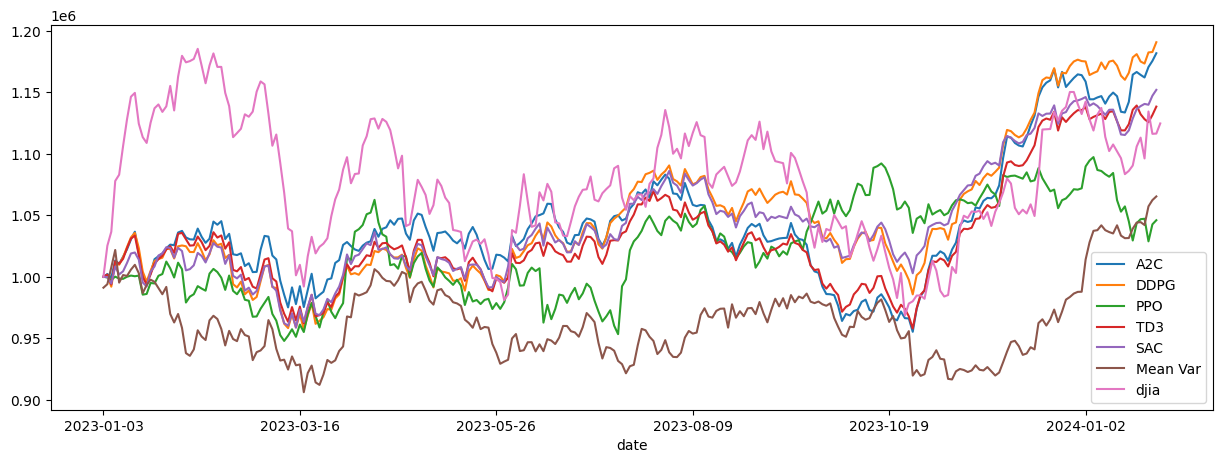

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()